In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=f5c1b1b3a928a9acc58c3d45171a04d40e40f2d38796f5dfe849e81c87c324e4
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [4]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

# Load the images directories
path = "/kaggle/input/apples-or-tomatoes-image-classification"
image_paths = list(paths.list_images(path))

In [5]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (300, 300))

    images.append(image)
    labels.append(label)

tomatoes


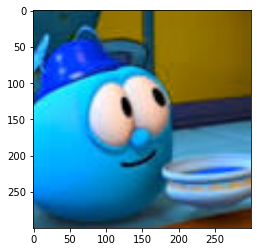

In [6]:
def plot_image(image):
    plt.imshow(image)
n=0
plot_image(images[n])
print(labels[n])

In [115]:
labels=[1 if labels[i]=='tomatoes' else 0 for i in range(len(labels))]
dict = {1 : 'tomatoes', 0 : 'apples'}

In [8]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [19]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.25, shuffle=True, stratify= labels)

In [162]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (300, 300, 3)), include_top= False)
top_model = base_model.output
top_model = AveragePooling2D(pool_size=(4, 4))(top_model)
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(2, activation='softmax')(top_model)

In [163]:
from keras.models import Model
for layer in base_model.layers:
    layer.trainable = False
model = Model(inputs=base_model.input, outputs=output_layer)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0  

In [164]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate= 0.001), metrics= ['accuracy'], loss= 'categorical_crossentropy')

In [165]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)
history = model.fit(train_X,train_Y, 
                              validation_data = (test_X, test_Y), 
                              epochs= 15, shuffle=True, batch_size=8)

Epoch 1/15
37/37 [==============================] - 3s 75ms/step - loss: 0.6461 - accuracy: 0.6962 - val_loss: 0.4187 - val_accuracy: 0.8163
Epoch 2/15
37/37 [==============================] - 2s 56ms/step - loss: 0.4259 - accuracy: 0.8225 - val_loss: 0.3777 - val_accuracy: 0.8469
Epoch 3/15
37/37 [==============================] - 2s 57ms/step - loss: 0.3153 - accuracy: 0.8840 - val_loss: 0.3589 - val_accuracy: 0.8367
Epoch 4/15
37/37 [==============================] - 2s 57ms/step - loss: 0.2883 - accuracy: 0.8908 - val_loss: 0.3206 - val_accuracy: 0.8469
Epoch 5/15
37/37 [==============================] - 2s 57ms/step - loss: 0.2669 - accuracy: 0.8942 - val_loss: 0.3189 - val_accuracy: 0.8673
Epoch 6/15
37/37 [==============================] - 2s 57ms/step - loss: 0.2097 - accuracy: 0.9283 - val_loss: 0.3023 - val_accuracy: 0.8673
Epoch 7/15
37/37 [==============================] - 2s 60ms/step - loss: 0.2156 - accuracy: 0.9113 - val_loss: 0.2998 - val_accuracy: 0.8673
Epoch 8/15
37

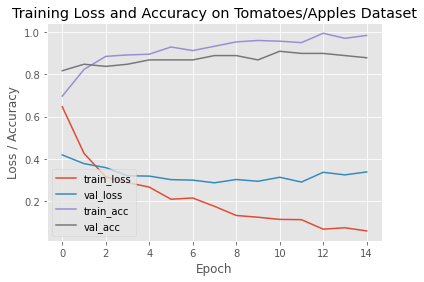

In [166]:
N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Tomatoes/Apples Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

In [167]:
predictions = model.predict(test_X)

In [168]:
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

In [169]:
errors = [1 if (predictions[i]!=actuals[i]) else 0 for i in range(len(predictions))]

apples tomatoes
8
tomatoes apples
14
apples tomatoes
19
apples tomatoes
23
apples tomatoes
33
tomatoes apples
34
apples tomatoes
50
tomatoes apples
55
apples tomatoes
61
apples tomatoes
69
tomatoes apples
80
apples tomatoes
97


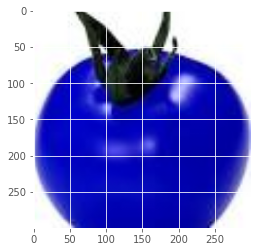

In [170]:
for i in range(len(errors)):
    if errors[i]==1:
        print(dict.get(predictions[i]), dict.get(actuals[i]))
        plot_image(test_X[i])
        print(i)

apples tomatoes


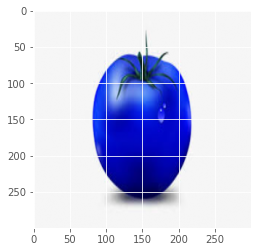

In [171]:
n=23
print(dict.get(predictions[n]), dict.get(actuals[n]))
plot_image(test_X[n])

In [172]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(actuals, predictions, target_names= ['Apples','Tomatoes']))
cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

      Apples       0.86      0.93      0.89        55
    Tomatoes       0.90      0.81      0.85        43

    accuracy                           0.88        98
   macro avg       0.88      0.87      0.87        98
weighted avg       0.88      0.88      0.88        98

[[51  4]
 [ 8 35]]


([<matplotlib.axis.YTick at 0x7fc93c639e50>,
 [Text(0, 0, 'Apples'), Text(0, 1, 'Tomatoes')])

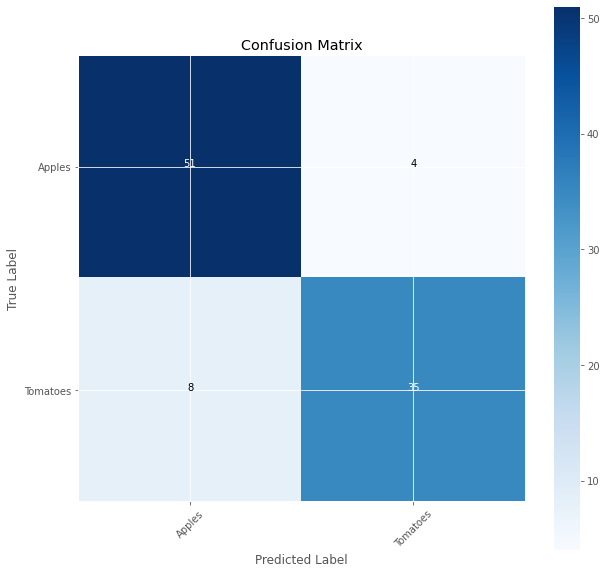

In [173]:
import itertools
classes=['Apples','Tomatoes']
tick_marks = np.arange(len(classes))
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)